## Importing the necessary libraries

In [1]:
# Importing the dependencies
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,preprocessing,Flatten
from keras import layers
import numpy as np
import os
from keras.applications.vgg16 import VGG16
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print("Everything imported successfully !")

Everything imported successfully !


In [2]:
# Let's check if jupyter is running on GPU or not
def check_gpu():
    if tf.test.is_gpu_available():
        print("Running on GPU")
    else:
        print("Not running of GPU")

check_gpu()

Running on GPU


When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [3]:
# Variable to keep track of number of corrupt images
num_skipped = 0

for folder_name in ("apple_scab", "black_rot","cedar_apple_rust","healthy"):
    # Path of all the above mentioned directories
    folder_path = os.path.join("dataset",folder_name)
    
    # Iterating through each and every file(image) in the respective directory
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
    
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)   
    
# Let's see how many corrupt images are there
print("Deleted %d images" % num_skipped)

Deleted 0 images


## Loading images to tensorflow dataset

In [4]:
# Loading the data into the tensorflow dataset
dataset = keras.preprocessing.image_dataset_from_directory("dataset/", batch_size=32, image_size=(256, 256), shuffle=True)
class_names = dataset.class_names


print("Class names are : ",class_names)
print(f"Our data is in total : {len(dataset)} batches")

Found 9714 files belonging to 4 classes.
Class names are :  ['apple_scab', 'black_rot', 'cedar_apple_rust', 'healthy']
Our data is in total : 304 batches


## Visualization of images 

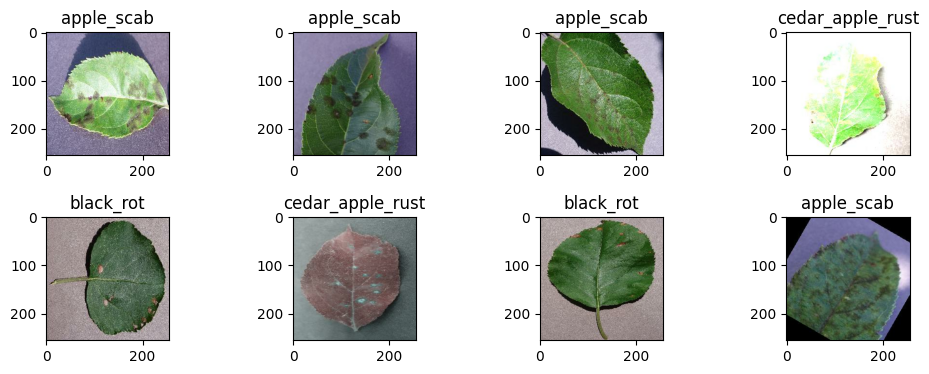

In [7]:
# Let's visualize one of the image from the batch
fig, ax = plt.subplots(2,4,figsize=(12, 4))

# Printing 8 images from the first batch of the dataset
for img_batch, label_batch in dataset.take(1):

    for i in range(2):
        for j in range(4):
            ax[i, j].set_title(class_names[label_batch[i * 4 + j]])
            ax[i, j].imshow(img_batch[i * 4 + j].numpy().astype("uint8"))

# Adjusting the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

## Creation of train test and validation batches

In [5]:
# training size, validation size, shuffle size
training_size = 0.8
validation_size = 0.1
shuffle_size = 10000

# Function for creating test, train and validation data batches
def train_test_val_batches(dataset, training_size, validation_size, shuffle_size):

    # Shuffling the dataset
    dataset = dataset.shuffle(shuffle_size, seed=12)

    # Creating batches for train, test, and validation
    train_dataset = dataset.take(int(len(dataset) * training_size)) #243 batches will be there in training dataset
    test_dataset = dataset.skip(int(len(dataset) * training_size)) # 60 in the test data
    validation_dataset = test_dataset.take(int(len(test_dataset) * validation_size))

    # Cache, Shuffle, and Prefetch the Datasets
    train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, test_dataset, validation_dataset


# Calling the function
train_ds, test_ds, val_ds = train_test_val_batches(dataset, training_size, validation_size, shuffle_size)

## Processing the images

For processing the raw images which includes data augmentation, image resizing, image rescaling etc we will be using the keras preprocessing layers API that will help us to build the preprocessing pipeline very much easily.

**Common Doubts**
1. Why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it.
2. Apply image preprocessing techniques like noise removal, sharpening, or contrast adjustment to enhance the visual features.
These techniques can help highlight important patterns and make the disease symptoms more distinguishable.
3. Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [6]:
# Image resizing and rescalinig
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(256, 256),
  layers.Rescaling(scale = 1./255),
])

# Create the data augmentation model
data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomCrop(100, 100),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

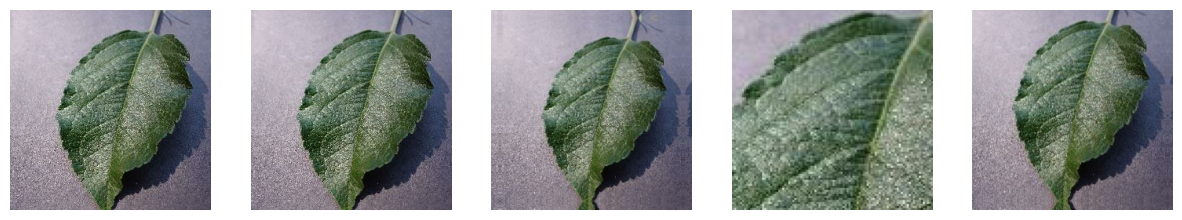

In [18]:
# Now just for testing let's take a single image and apply preprocessing on it
for img,labels in train_ds.take(1):
    single_img = img[0].numpy()
    break

# Apply data augmentation to the single image
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, layer in enumerate(data_augmentation_layer.layers):
    augmented_image = layer(tf.expand_dims(single_img, axis=0), training=True)
    ax[i].imshow(augmented_image[0].numpy().astype("uint8"))
    ax[i].axis("off")

plt.show()

## CNN model training

In [7]:
# Let's download the VGG16 model
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)
conv_base.trainable = False

In [8]:
def build_model():
    """
    This method will return us a model with all the layers configured
    """
    model = Sequential()

    resize_and_rescale,
    data_augmentation_layer,
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model = build_model()
model.summary()
history = model.fit(train_ds,batch_size=32,epochs=10,validation_data=val_ds,verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23,103,809
Trainable params: 8,389,121
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(train_ds,batch_size=32,epochs=10,validation_data=val_ds,verbose=1)

Epoch 1/10


## Model evaluation

In [10]:
# Saving the model
current_model_version = 1
model.save(f"Models/{current_model_version}")